In [208]:
from act4brd.graph import create_street_grid
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp

In [209]:
g, pos = create_street_grid(2,2)
depot = 0
schools = [1]

C:\Users\diego\AppData\Local\Temp\ipykernel_28948\4103280198.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


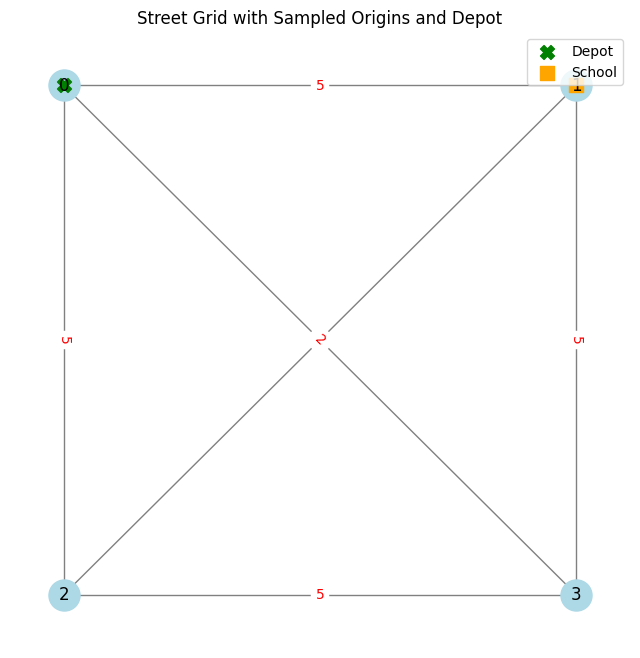

In [210]:
g = nx.Graph()
node_mapping = {}  # Map (row, col) to a unique integer
counter = 0

for i in range(2):
    for j in range(2):
        node_mapping[(i, j)] = counter
        counter += 1

for i in range(2):
    for j in range(2):
        if i > 0:
            g.add_edge(node_mapping[(i, j)], node_mapping[(i - 1, j)], weight=5)
        if j > 0:
            g.add_edge(node_mapping[(i, j)], node_mapping[(i, j - 1)], weight=5)

g.add_edge(node_mapping[(0, 0)], node_mapping[(1, 1)], weight=2)  # Diagonal edge with different weight
g.add_edge(node_mapping[(0, 1)], node_mapping[(1, 0)], weight=2)  # Another diagonal edge with different weight

# Add length attribute to edges
for u, v in g.edges():
    g.edges[u, v]['length'] = 1

# Generate positions for nodes (2D grid layout)
pos = {node_mapping[(x, y)]: (y, -x) for x, y in node_mapping.keys()}

# Randomly sample 20 points in the 2D space [min(p[0]), max(p[0])] x [min(p[1]), max(p[1])] for p in pos.values()
origins = []

g.nodes[2]['demand'] = 5
# in the future, make mapping using dict
student_mapping = {(2,schools[0]): 5}

# Visualize the graph and sampled points
fig, ax = plt.subplots(figsize=(8,8))
# label edges with weights
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in g.edges(data=True)}
nx.draw(g, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, ax=ax)
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red', ax=ax)

# Plot the depot and schools
ax.scatter(pos[depot][0], pos[depot][1], color='green', s=100, label='Depot', marker='X', zorder=2)
for school in schools:
    ax.scatter(pos[school][0], pos[school][1], color='orange', s=100, label='School', marker='s', zorder=2)

ax.legend()
ax.set_title('Street Grid with Sampled Origins and Depot')
fig.show()

In [211]:
x = cp.Variable((len(g.nodes),len(g.nodes))) # variable indicating if edge (i, j) is in the route

constraints = []

# for i, j in g.edges():
#     if i == j or i in schools or j in schools or i == depot or j == depot:
#         continue
#     constraints.append(cp.sum(x[i, j]) - cp.sum(x[j, i]) == 0)  # intermediate node flow conservation constraints

# for i in g.nodes():
#     if i != depot:
#         constraints.append(cp.sum(x[depot, i]) - cp.sum(x[i, depot]) == 1)  # Depot flow constraint
#     if i not in schools:
#         constraints.append(cp.sum(x[schools[0], i]) - cp.sum(x[i, schools[0]]) == -1)  # School flow constraint

# for i in g.nodes():
#     val = 1 if i == depot else (-1 if i == schools[0] else 0)
#     neighbors = list(g.neighbors(i))
#     for j in neighbors:
#         for k in neighbors:
#             if j == k:
#                 continue
#             constraints.append(x[i, j] - x[k, i] == val)  # Flow conservation constraints

for i in g.nodes():
    for school in schools:
        if i != school and school in g.neighbors(i):
            constraints.append(cp.sum(x[school, i]) == 1)  # School flow conservation constraints

    if i != depot and depot in g.neighbors(i):
        constraints.append(cp.sum(x[i, depot]) == 1)  # Depot flow conservation constraints

    if i not in schools and i != depot:
        for j in g.neighbors(i):
            if j != depot and j not in schools:
                constraints.append(x[i, j] - x[j, i] == 0)  # Intermediate node flow conservation constraints

constraints.append(x >= 0)  # Non-negativity constraints

In [212]:
[neighbor for neighbor in g.neighbors(i)]

[1, 2, 0]

In [213]:
# Objective: minimize total distance traveled
obj = cp.Minimize(cp.sum([cp.multiply(x[i, j], weight) for i, j, weight in g.edges.data("weight")]))

In [214]:
prob = cp.Problem(obj, constraints)
print("Solving MILP")
try:
    # Try with verbose to see progress; set a reasonable time limit
    prob.solve(solver=cp.GLPK_MI, verbose=True, glpk={'msg_lev': 'GLP_MSG_ON', 'tm_lim': 2*60*1000})  # 2-min limit
except Exception as e:
    print(f"⚠️  GLPK_MI failed or unavailable: {e}")
    print("Trying CBC as fallback...")
    try:
        prob.solve(solver=cp.CBC, verbose=True, maximumSeconds=120)
    except Exception as e2:
        print(f"⚠️  CBC also failed: {e2}")
        print("Trying default solver...")
        prob.solve(verbose=True)

print()
print("Status:", prob.status)
print("Objective (total distance):", prob.value)

(CVXPY) Feb 17 07:39:55 PM: Your problem has 16 variables, 24 constraints, and 0 parameters.
(CVXPY) Feb 17 07:39:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 17 07:39:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 17 07:39:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 17 07:39:55 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Feb 17 07:39:55 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Feb 17 07:39:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GLPK_MI
(CVXPY) Feb 17 07:39:55 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 17 07:39:55 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 17 07:39:55 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 17 07:39:55 PM: Applying reduction GLPK_MI
(CVXPY) Feb 17 07:39:55 PM: Finished problem compilation

Solving MILP
                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------

Status: optimal
Objective (total distance): 12.0


In [215]:
# Extract and print the route
if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    print(f"⚠️ Solver did not find a feasible solution (status={prob.status}).")
else:
    print("Selected edges in the route:")
    for i, j in g.edges():
        if x[i, j].value is not None and x[i, j].value > 0.5: 
            print(f"Edge ({i}, {j}) with weight {g.edges[i, j]['weight']}")

Selected edges in the route:
Edge (1, 0) with weight 5
Edge (1, 3) with weight 5
Edge (1, 2) with weight 2


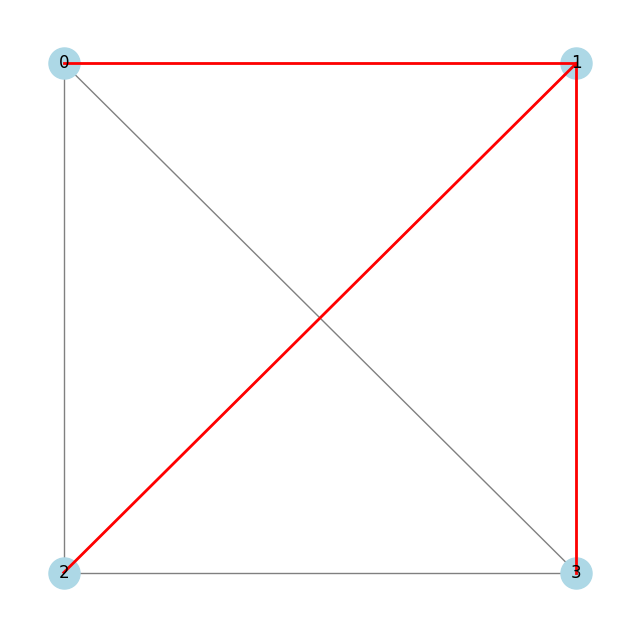

In [216]:
# Plot routes chosen by the solver
fig, ax = plt.subplots(figsize=(8,8))
nx.draw(g, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, ax=ax)
ax.scatter(pos[depot][0], pos[depot][1], color='green', s=100, label='Depot', marker='X')
for i, j in g.edges(): 
    if x[i, j].value is not None and x[i, j].value > 0.5:  # Assuming binary variables
        ax.plot([pos[i][0], pos[j][0]], [pos[i][1], pos[j][1]], color='red', linewidth=2)